# Setup

## Import Libraries

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import requests
import os
import plotly.offline as po
import plotly.graph_objs as pg
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import warnings
import statsmodels.formula.api as smf


from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.stats.anova import anova_lm

#Seanborn styling
sns.set_style("darkgrid")

## Load Data

In [2]:
warnings.filterwarnings("ignore", category = UserWarning, module = "openpyxl")

# Edgap.org data
edgap = pd.read_excel(
    'https://raw.githubusercontent.com/brian-fischer/DATA-5100/main/EdGap_data.xlsx',
    dtype = {'NCESSCH School ID': object}
)

# School information
url = 'https://www.dropbox.com/s/lkl5nvcdmwyoban/ccd_sch_029_1617_w_1a_11212017.csv?dl=1'

## Download / save the the file 
data_folder = os.path.join('..', 'data')
os.makedirs(data_folder, exist_ok = True)

ccd_base = os.path.join(data_folder, 'ccd_sch_029_1617_w_1a_11212017.csv')
ccd_member = os.path.join(data_folder, 'ccd_sch_member.csv')
ccd_staff = os.path.join(data_folder, 'ccd_sch_staff.csv')


response = requests.get(url)
response.raise_for_status()

with open(ccd_base, 'wb') as file:
    file.write(response.content)

In [3]:
school_base_information = pd.read_csv(
    ccd_base, dtype = {'NCESSCH': object}, low_memory = False, encoding = 'unicode_escape'
    )

school_member = pd.read_csv(
    ccd_member, dtype = {'NCESSCH': object}, low_memory = False, encoding = 'unicode_escape'
    )

school_staff = pd.read_csv(
    ccd_staff, dtype = {'NCESSCH': object}, low_memory = False, encoding = 'unicode_escape'
    )

# Data Inspection

## Edgap.edu data

In [4]:
edgap.head()

NCESSCH School ID  CT Unemployment Rate  CT Pct Adults with College Degree  \
0      100001600143              0.117962                           0.445283   
1      100008000024              0.063984                           0.662765   
2      100008000225              0.056460                           0.701864   
3      100017000029              0.044739                           0.692062   
4      100018000040              0.077014                           0.640060   

   CT Pct Childre In Married Couple Family  CT Median Household Income  \
0                                 0.346495                     42820.0   
1                                 0.767619                     89320.0   
2                                 0.713090                     84140.0   
3                                 0.641283                     56500.0   
4                                 0.834402                     54015.0   

   School ACT average (or equivalent if SAT score)  \
0                                        20.433455   
1                                        19.498168   
2                                        19.554335   
3                                        17.737485   
4                                        18.245421   

   School Pct Free and Reduced Lunch  
0                           0.066901  
1                           0.112412  
2                           0.096816  
3                           0.296960  
4                           0.262641

In [5]:
edgap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7986 entries, 0 to 7985
Data columns (total 7 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   NCESSCH School ID                                7986 non-null   object 
 1   CT Unemployment Rate                             7972 non-null   float64
 2   CT Pct Adults with College Degree                7973 non-null   float64
 3   CT Pct Childre In Married Couple Family          7961 non-null   float64
 4   CT Median Household Income                       7966 non-null   float64
 5   School ACT average (or equivalent if SAT score)  7986 non-null   float64
 6   School Pct Free and Reduced Lunch                7986 non-null   float64
dtypes: float64(6), object(1)
memory usage: 436.9+ KB


- Checking for missing values, data types, and number of places the data was gathered from. 
    - This helps understand the dataframe so the data can be processed accurately.

## School Information data

In [6]:
pd.set_option('display.max_columns', None)

school_base_information.head()

SCHOOL_YEAR  FIPST STATENAME  ST                          SCH_NAME  \
0   2016-2017      1   ALABAMA  AL  Sequoyah Sch - Chalkville Campus   
1   2016-2017      1   ALABAMA  AL                             Camps   
2   2016-2017      1   ALABAMA  AL                           Det Ctr   
3   2016-2017      1   ALABAMA  AL     Wallace Sch - Mt Meigs Campus   
4   2016-2017      1   ALABAMA  AL         McNeel Sch - Vacca Campus   

                 LEA_NAME STATE_AGENCY_NO  UNION ST_LEAID    LEAID  \
0  Alabama Youth Services              01    NaN   AL-210  0100002   
1  Alabama Youth Services              01    NaN   AL-210  0100002   
2  Alabama Youth Services              01    NaN   AL-210  0100002   
3  Alabama Youth Services              01    NaN   AL-210  0100002   
4  Alabama Youth Services              01    NaN   AL-210  0100002   

      ST_SCHID       NCESSCH     SCHID           MSTREET1 MSTREET2 MSTREET3  \
0  AL-210-0020  010000200277  100277.0       P O Box 9486      NaN      NaN   
1  AL-210-0050  010000201667  101667.0         P O Box 66      NaN      NaN   
2  AL-210-0060  010000201670  101670.0         P O Box 66      NaN      NaN   
3  AL-210-0030  010000201705  101705.0         P O Box 66      NaN      NaN   
4  AL-210-0040  010000201706  101706.0  8950 Roebuck Blvd      NaN      NaN   

         MCITY MSTATE   MZIP MZIP4                     LSTREET1 LSTREET2  \
0   Birmingham     AL  35220   NaN  1000 Industrial School Road      NaN   
1     Mt Meigs     AL  36057   NaN           1601 County Rd. 57      NaN   
2     Mt Meigs     AL  36057   NaN       2109 Bashi Rd Bldg 509      NaN   
3  Mount Meigs     AL  36057   NaN  1000 Industrial School Road      NaN   
4   Birmingham     AL  35206   NaN            8950 Roebuck Blvd      NaN   

  LSTREET3        LCITY LSTATE   LZIP LZIP4          PHONE  \
0      NaN   Birmingham     AL  35220   NaN  (205)680-8574   
1      NaN   Prattville     AL  36067   NaN  (334)215-3850   
2      NaN  Thomasville     AL  36784   NaN  (334)215-3850   
3      NaN  Mount Meigs     AL  36057   NaN  (334)215-6039   
4      NaN   Birmingham     AL  35206   NaN  (205)838-4981   

                      WEBSITE SY_STATUS SY_STATUS_TEXT UPDATED_STATUS  \
0  http://www.dys.alabama.gov         1           Open              1   
1  http://www.dys.alabama.gov         1           Open              1   
2  http://www.dys.alabama.gov         1           Open              1   
3  http://www.dys.alabama.gov         1           Open              1   
4  http://www.dys.alabama.gov         1           Open              1   

  UPDATED_STATUS_TEXT EFFECTIVE_DATE       SCH_TYPE_TEXT SCH_TYPE  \
0                Open     03/03/2010  Alternative School        4   
1                Open     03/03/2010  Alternative School        4   
2                Open     03/03/2010  Alternative School        4   
3                Open     03/03/2010  Alternative School        4   
4                Open     03/03/2010  Alternative School        4   

  RECON_STATUS OUT_OF_STATE_FLAG CHARTER_TEXT CHARTAUTH1 CHARTAUTHN1  \
0           No                No           No        NaN         NaN   
1           No                No           No        NaN         NaN   
2           No                No           No        NaN         NaN   
3           No                No           No        NaN         NaN   
4           No                No           No        NaN         NaN   

  CHARTAUTH2 CHARTAUTHN2 NOGRADES G_PK_OFFERED G_KG_OFFERED G_1_OFFERED  \
0        NaN         NaN       No           No           No          No   
1        NaN         NaN       No           No           No          No   
2        NaN         NaN       No           No           No          No   
3        NaN         NaN       No           No           No          No   
4        NaN         NaN       No           No           No          No   

  G_2_OFFERED G_3_OFFERED G_4_OFFERED G_5_OFFERED G_6_OFFERED G_7_OFFERED  \
0          No          No   

In [7]:
school_member.head()

SCHOOL_YEAR  FIPST STATENAME  ST                          SCH_NAME  \
0   2016-2017      1   ALABAMA  AL  Sequoyah Sch - Chalkville Campus   
1   2016-2017      1   ALABAMA  AL  Sequoyah Sch - Chalkville Campus   
2   2016-2017      1   ALABAMA  AL  Sequoyah Sch - Chalkville Campus   
3   2016-2017      1   ALABAMA  AL  Sequoyah Sch - Chalkville Campus   
4   2016-2017      1   ALABAMA  AL  Sequoyah Sch - Chalkville Campus   

   STATE_AGENCY_NO  UNION ST_LEAID   LEAID     ST_SCHID       NCESSCH   SCHID  \
0                1    NaN   AL-210  100002  AL-210-0020  010000200277  100277   
1                1    NaN   AL-210  100002  AL-210-0020  010000200277  100277   
2                1    NaN   AL-210  100002  AL-210-0020  010000200277  100277   
3                1    NaN   AL-210  100002  AL-210-0020  010000200277  100277   
4                1    NaN   AL-210  100002  AL-210-0020  010000200277  100277   

      GRADE                    RACE_ETHNICITY     SEX  STUDENT_COUNT  \
0  Grade 10  American Indian or Alaska Native  Female            NaN   
1  Grade 10  American Indian or Alaska Native    Male            NaN   
2  Grade 10                             Asian  Female            NaN   
3  Grade 10                             Asian    Male            NaN   
4  Grade 10         Black or African American  Female            NaN   

                                  TOTAL_INDICATOR      DMS_FLAG  
0  Category Set A - By Race/Ethnicity; Sex; Grade  Not reported  
1  Category Set A - By Race/Ethnicity; Sex; Grade  Not reported  
2  Category Set A - By Race/Ethnicity; Sex; Grade  Not reported  
3  Category Set A - By Race/Ethnicity; Sex; Grade  Not reported  
4  Category Set A - By Race/Ethnicity; Sex; Grade  Not reported

In [8]:
school_staff.head()

SCHOOL_YEAR  FIPST STATENAME  ST                          SCH_NAME  \
0   2016-2017      1   ALABAMA  AL  Sequoyah Sch - Chalkville Campus   
1   2016-2017      1   ALABAMA  AL                             Camps   
2   2016-2017      1   ALABAMA  AL                           Det Ctr   
3   2016-2017      1   ALABAMA  AL     Wallace Sch - Mt Meigs Campus   
4   2016-2017      1   ALABAMA  AL         McNeel Sch - Vacca Campus   

   STATE_AGENCY_NO  UNION ST_LEAID   LEAID     ST_SCHID       NCESSCH   SCHID  \
0                1    NaN   AL-210  100002  AL-210-0020  010000200277  100277   
1                1    NaN   AL-210  100002  AL-210-0050  010000201667  101667   
2                1    NaN   AL-210  100002  AL-210-0060  010000201670  101670   
3                1    NaN   AL-210  100002  AL-210-0030  010000201705  101705   
4                1    NaN   AL-210  100002  AL-210-0040  010000201706  101706   

   TEACHERS       TOTAL_INDICATOR  DMS_FLAG  
0       0.0  Education Unit Total  Reported  
1       0.0  Education Unit Total  Reported  
2       0.0  Education Unit Total  Reported  
3       0.0  Education Unit Total  Reported  
4       0.0  Education Unit Total  Reported

In [9]:
school_base_information.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102183 entries, 0 to 102182
Data columns (total 65 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   SCHOOL_YEAR          102183 non-null  object 
 1   FIPST                102183 non-null  int64  
 2   STATENAME            102183 non-null  object 
 3   ST                   102183 non-null  object 
 4   SCH_NAME             102183 non-null  object 
 5   LEA_NAME             102183 non-null  object 
 6   STATE_AGENCY_NO      102183 non-null  object 
 7   UNION                2533 non-null    float64
 8   ST_LEAID             102183 non-null  object 
 9   LEAID                102183 non-null  object 
 10  ST_SCHID             102183 non-null  object 
 11  NCESSCH              102181 non-null  object 
 12  SCHID                102181 non-null  float64
 13  MSTREET1             102181 non-null  object 
 14  MSTREET2             1825 non-null    object 
 15  MSTREET3         

In [10]:
school_member.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12279594 entries, 0 to 12279593
Data columns (total 18 columns):
 #   Column           Dtype  
---  ------           -----  
 0   SCHOOL_YEAR      object 
 1   FIPST            int64  
 2   STATENAME        object 
 3   ST               object 
 4   SCH_NAME         object 
 5   STATE_AGENCY_NO  int64  
 6   UNION            float64
 7   ST_LEAID         object 
 8   LEAID            int64  
 9   ST_SCHID         object 
 10  NCESSCH          object 
 11  SCHID            int64  
 12  GRADE            object 
 13  RACE_ETHNICITY   object 
 14  SEX              object 
 15  STUDENT_COUNT    float64
 16  TOTAL_INDICATOR  object 
 17  DMS_FLAG         object 
dtypes: float64(2), int64(4), object(12)
memory usage: 1.6+ GB


In [11]:
school_staff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100062 entries, 0 to 100061
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   SCHOOL_YEAR      100062 non-null  object 
 1   FIPST            100062 non-null  int64  
 2   STATENAME        100062 non-null  object 
 3   ST               100062 non-null  object 
 4   SCH_NAME         100062 non-null  object 
 5   STATE_AGENCY_NO  100062 non-null  int64  
 6   UNION            2488 non-null    float64
 7   ST_LEAID         100062 non-null  object 
 8   LEAID            100062 non-null  int64  
 9   ST_SCHID         100062 non-null  object 
 10  NCESSCH          100062 non-null  object 
 11  SCHID            100062 non-null  int64  
 12  TEACHERS         96438 non-null   float64
 13  TOTAL_INDICATOR  100062 non-null  object 
 14  DMS_FLAG         100062 non-null  object 
dtypes: float64(2), int64(4), object(9)
memory usage: 11.5+ MB


- Checking for missing values and data types for each of the csv's loaded in.
    - This helps understand the dataframe so the data can be processed accurately.
- Will need to aggregate student count data from the membership dataset.
    - Currently split by Grade, Race /  Ethnicity, and Sex

## Inspection Visualizations

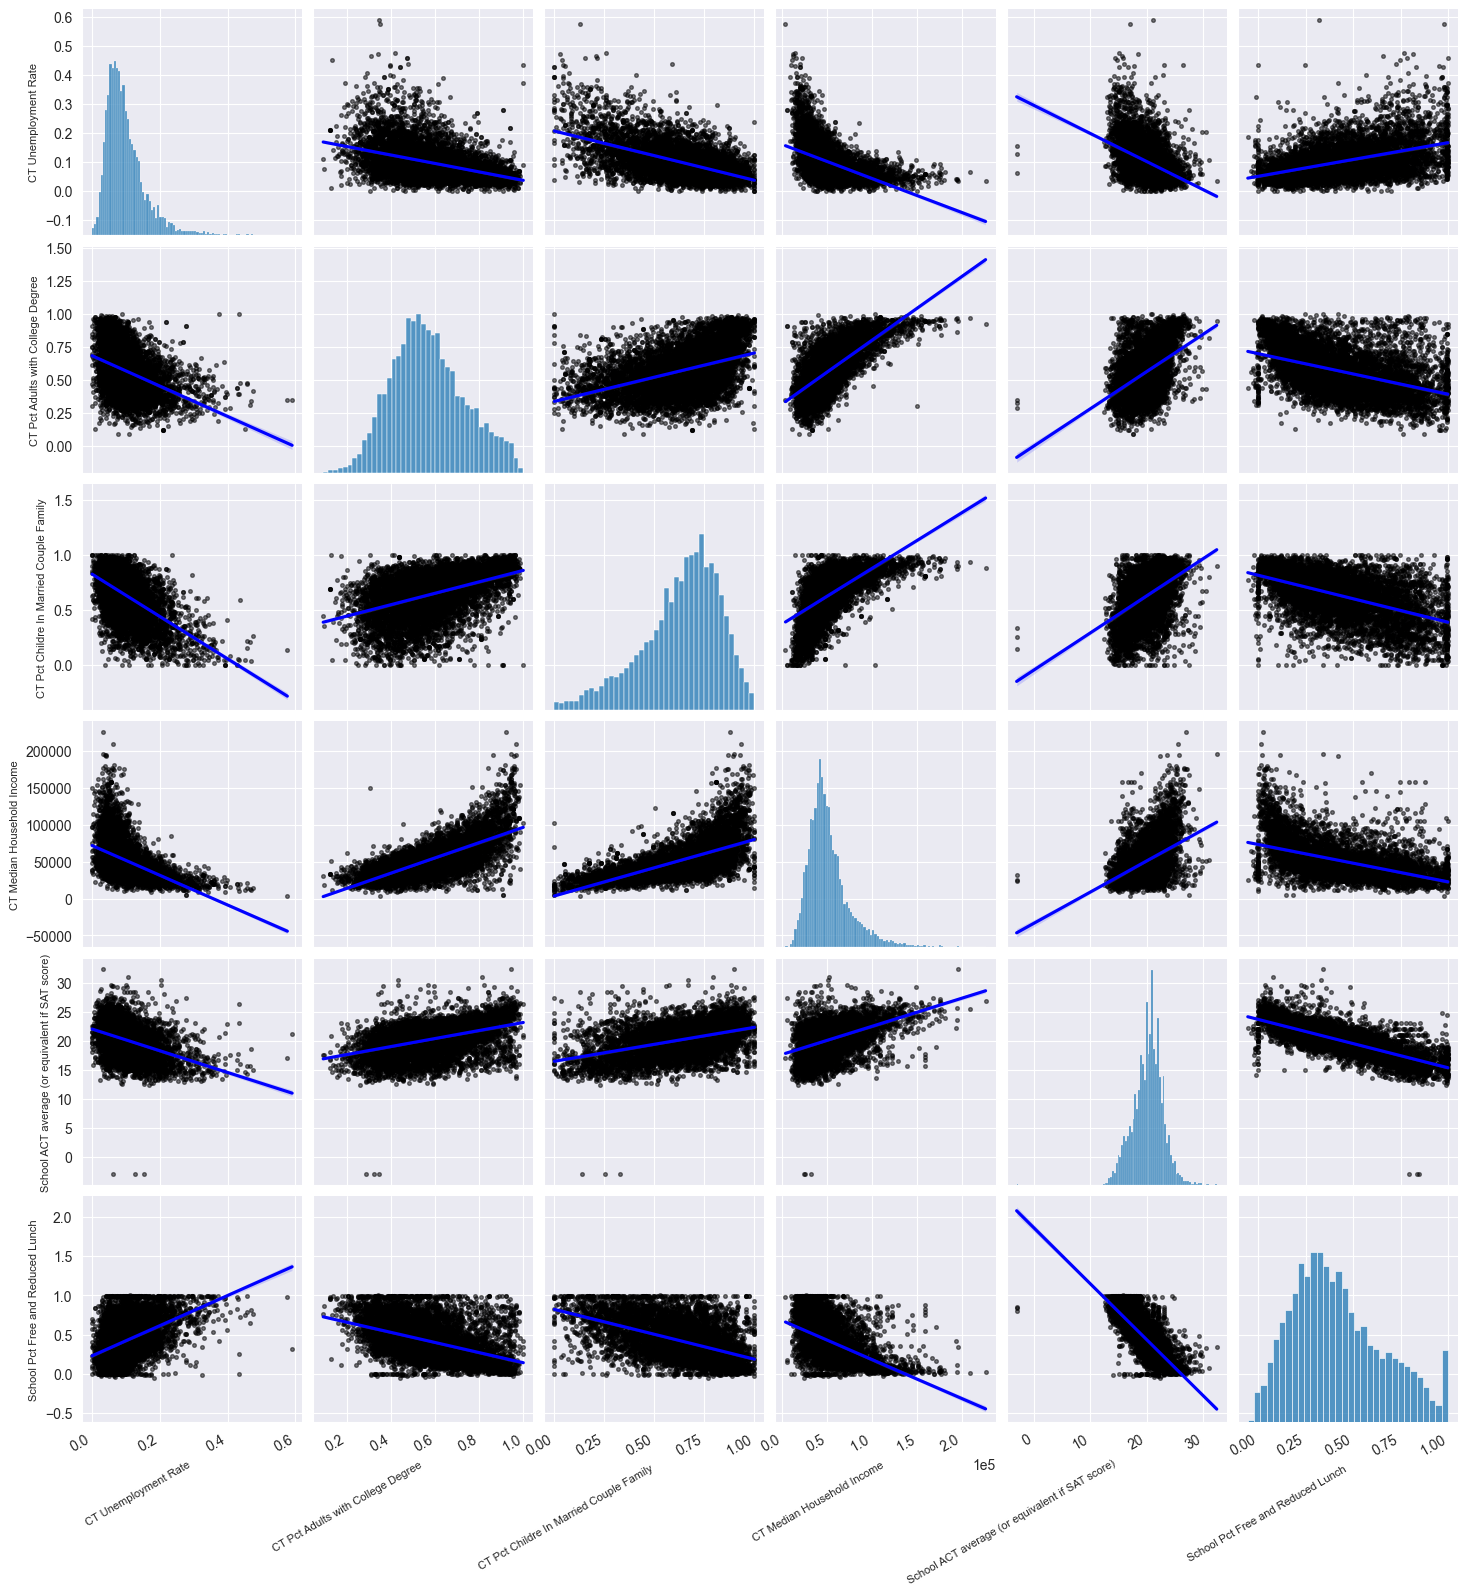

In [12]:
fig = sns.pairplot(
    edgap.drop(columns = "NCESSCH School ID"),
    kind = "reg",
    plot_kws = {
        "line_kws": {"color": "blue"},
        "scatter_kws": {"alpha": 0.5, "color": "k", "s": 7},
    },
)

for ax in fig.axes.flat:
    if ax.get_xlabel() == 'CT Median Household Income':
        ax.ticklabel_format(style='sci', axis='x', scilimits = (0,0))  # Apply scientific notation
    ax.set_xlabel(ax.get_xlabel(), fontsize = 8, rotation = 30, ha = 'right')  # X-axis label size and rotation
    ax.set_ylabel(ax.get_ylabel(), fontsize = 8)  # Y-axis label size

    # Rotate x-axis tick labels
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

plt.show()

- The pairplot shows the relationships between each of the variables.
- They show that there is some relationship betwen the socioeconmoic variables and the ACT score, but that the data should be cleaned up.

# Data Processing

## Selecting data subsets

In [13]:
school_base_information = school_base_information[
    ['SCHOOL_YEAR', 'NCESSCH', 'LSTATE', 'LZIP', 'SCH_TYPE_TEXT', 'LEVEL', 'CHARTER_TEXT']
]

print(school_base_information.head())
print()
print("*" * 70)
print()
print(school_base_information.info())


  SCHOOL_YEAR       NCESSCH LSTATE   LZIP       SCH_TYPE_TEXT LEVEL  \
0   2016-2017  010000200277     AL  35220  Alternative School  High   
1   2016-2017  010000201667     AL  36067  Alternative School  High   
2   2016-2017  010000201670     AL  36784  Alternative School  High   
3   2016-2017  010000201705     AL  36057  Alternative School  High   
4   2016-2017  010000201706     AL  35206  Alternative School  High   

  CHARTER_TEXT  
0           No  
1           No  
2           No  
3           No  
4           No  

**********************************************************************

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102183 entries, 0 to 102182
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   SCHOOL_YEAR    102183 non-null  object
 1   NCESSCH        102181 non-null  object
 2   LSTATE         102183 non-null  object
 3   LZIP           102183 non-null  object
 4   SCH_TYPE_TEXT  1021

### Renaming columns

In [14]:
edgap = edgap.rename(
    columns={
        "NCESSCH School ID": "id",
        "CT Pct Adults with College Degree": "percent_college",
        "CT Unemployment Rate": "rate_unemployment",
        "CT Pct Childre In Married Couple Family": "percent_married",
        "CT Median Household Income": "median_income",
        "School ACT average (or equivalent if SAT score)": "average_act",
        "School Pct Free and Reduced Lunch": "percent_lunch",
    }
)

#edgap.head()
print(edgap.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7986 entries, 0 to 7985
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 7986 non-null   object 
 1   rate_unemployment  7972 non-null   float64
 2   percent_college    7973 non-null   float64
 3   percent_married    7961 non-null   float64
 4   median_income      7966 non-null   float64
 5   average_act        7986 non-null   float64
 6   percent_lunch      7986 non-null   float64
dtypes: float64(6), object(1)
memory usage: 436.9+ KB
None


In [15]:
school_base_information = school_base_information.rename(
    columns = {
        "SCHOOL_YEAR": "year",
        "NCESSCH": "id",
        "LSTATE": "state",
        "LZIP": "zip_code",
        "SCH_TYPE_TEXT": "school_type",
        "LEVEL": "school_level",
        "CHARTER_TEXT": "charter"
    }
)

#school_base_information.head()
print(school_base_information.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102183 entries, 0 to 102182
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   year          102183 non-null  object
 1   id            102181 non-null  object
 2   state         102183 non-null  object
 3   zip_code      102183 non-null  object
 4   school_type   102181 non-null  object
 5   school_level  102179 non-null  object
 6   charter       102179 non-null  object
dtypes: object(7)
memory usage: 5.5+ MB
None


## Student Teach Ratio

### Total student count

In [ ]:
# Total student count per school
high_school_grades = ['Grade 9', 'Grade 10', 'Grade 11', 'Grade 12']
high_school_data = school_member[school_member['GRADE'].isin(high_school_grades)]

student_totals = high_school_data.groupby('NCESSCH', as_index = False)['STUDENT_COUNT'].sum()
student_totals = student_totals.rename(columns = {'STUDENT_COUNT': 'total_students'})

print(student_totals.head())
print()
print("*" * 40)
print()
print(student_totals.info())
print()
print("*" * 40)
print()
print(student_totals.describe())

        NCESSCH  total_students
0  010000200277             0.0
1  010000201667             0.0
2  010000201670             0.0
3  010000201705             0.0
4  010000201706             0.0

****************************************

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34376 entries, 0 to 34375
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   NCESSCH         34376 non-null  object 
 1   total_students  34376 non-null  float64
dtypes: float64(1), object(1)
memory usage: 537.3+ KB
None

****************************************

       total_students
count    34376.000000
mean       882.147661
std       1341.122123
min          0.000000
25%          2.000000
50%        280.000000
75%       1114.000000
max      23414.000000


- To get a count of students per school id (NCESSCH) the grade was filtered in order to only contain highschool grades.
    - Then each school id was grouped and the student count was totaled for it.
- Inspects the new combined data to get more details on how to move forward.

### Staff count

In [28]:
#Getting staff count for each school from staff dataset
teacher_totals = school_staff[['NCESSCH', 'TEACHERS']].copy()

teacher_totals = teacher_totals.rename(columns = {'TEACHERS': 'staff'})
teacher_totals['staff'] = pd.to_numeric(teacher_totals['staff'], errors = 'coerce')

print(teacher_totals.head())
print()
print("*" * 40)
print()
print(teacher_totals.info())
print()
print("*" * 40)
print()
print(teacher_totals.describe())

        NCESSCH  staff
0  010000200277    0.0
1  010000201667    0.0
2  010000201670    0.0
3  010000201705    0.0
4  010000201706    0.0

****************************************

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100062 entries, 0 to 100061
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   NCESSCH  100062 non-null  object 
 1   staff    96438 non-null   float64
dtypes: float64(1), object(1)
memory usage: 1.5+ MB
None

****************************************

              staff
count  96438.000000
mean      32.451696
std       25.439461
min        0.000000
25%       17.000000
50%       27.500000
75%       40.920000
max     1369.000000


- Keeps only the count of staff per school since the goal is to get the student / teacher ratio

### Merge student totals and teacher count

In [60]:
ratio_df = pd.merge(
    student_totals,
    teacher_totals,
    on = 'NCESSCH',
    how = 'inner'
)

ratio_df = ratio_df.rename(columns={'NCESSCH': 'id'})

ratio_df.loc[ratio_df['staff'] < 1, 'staff'] = np.nan

ratio_df['student_staff_ratio'] = ratio_df['total_students'] / ratio_df['staff']
ratio_df = ratio_df.dropna(subset=['student_staff_ratio'])

ratio_df = ratio_df[ratio_df['total_students'] > 0] 

ratio_df = ratio_df[
    (ratio_df['student_staff_ratio'] > 5) &
    (ratio_df['student_staff_ratio'] < 50)
]

print(ratio_df.max())
print()
print("*" * 80)
print()
print(ratio_df.info())
print()
print("*" * 80)
print()
print(ratio_df.describe())

id                     780003000015
total_students              23414.0
staff                         570.1
student_staff_ratio       49.988782
dtype: object

********************************************************************************

<class 'pandas.core.frame.DataFrame'>
Index: 21847 entries, 6 to 34375
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   21847 non-null  object 
 1   total_students       21847 non-null  float64
 2   staff                21847 non-null  float64
 3   student_staff_ratio  21847 non-null  float64
dtypes: float64(3), object(1)
memory usage: 853.4+ KB
None

********************************************************************************

       total_students         staff  student_staff_ratio
count    21847.000000  21847.000000         21847.000000
mean      1285.630430     43.408054            26.132579
std       1425.364932     39.630750        

- Joins the dataframe created for student total per school with the dataframe for staff per school. 
- Creates a new column for the student to staff ratio to later merge with the other dataframes.

## Join dataframes

### Edgap and School Information

In [61]:
edgap['id'] = edgap['id'].astype(str)
school_base_information['id'] = school_base_information['id'].astype(str)

edgap['id'] = edgap['id'].str.zfill(12)
school_base_information['id'] = school_base_information['id'].str.zfill(12)

df = edgap.merge(
    school_base_information,
    how = 'left',
    on = 'id'
)

print(df.head())
print()
print("*" * 40)
print()
print(df.info())

             id  rate_unemployment  percent_college  percent_married  \
0  100001600143           0.117962         0.445283         0.346495   
1  100008000024           0.063984         0.662765         0.767619   
2  100008000225           0.056460         0.701864         0.713090   
3  100017000029           0.044739         0.692062         0.641283   
4  100018000040           0.077014         0.640060         0.834402   

   median_income  average_act  percent_lunch       year state zip_code  \
0        42820.0    20.433455       0.066901  2016-2017    DE    19804   
1        89320.0    19.498168       0.112412  2016-2017    DE    19709   
2        84140.0    19.554335       0.096816  2016-2017    DE    19709   
3        56500.0    17.737485       0.296960  2016-2017    DE    19958   
4        54015.0    18.245421       0.262641  2016-2017    DE    19934   

      school_type school_level charter  
0  Regular School         High     Yes  
1  Regular School         High      No  

- Joins the schools base information dataframe with the edgap dataset.

### Merged Edgap + School Information and Student Teacher Ratio

In [62]:
ratio_df['id'] = ratio_df['id'].astype(str).str.split('.').str[0].str.zfill(12)

df = df.merge(
    ratio_df,
    how = 'left',
    on = 'id'
)

print(df.head())
print()
print("*" * 40)
print()
df.describe()

             id  rate_unemployment  percent_college  percent_married  \
0  100001600143           0.117962         0.445283         0.346495   
1  100008000024           0.063984         0.662765         0.767619   
2  100008000225           0.056460         0.701864         0.713090   
3  100017000029           0.044739         0.692062         0.641283   
4  100018000040           0.077014         0.640060         0.834402   

   median_income  average_act  percent_lunch       year state zip_code  \
0        42820.0    20.433455       0.066901  2016-2017    DE    19804   
1        89320.0    19.498168       0.112412  2016-2017    DE    19709   
2        84140.0    19.554335       0.096816  2016-2017    DE    19709   
3        56500.0    17.737485       0.296960  2016-2017    DE    19958   
4        54015.0    18.245421       0.262641  2016-2017    DE    19934   

      school_type school_level charter  total_students  staff  \
0  Regular School         High     Yes          1168.0   

rate_unemployment  percent_college  percent_married  median_income  \
count        7972.000000      7973.000000      7961.000000    7966.000000   
mean            0.098730         0.568930         0.633440   52026.905222   
std             0.058959         0.165704         0.196764   24228.057079   
min             0.000000         0.091493         0.000000    3589.000000   
25%             0.058655         0.450828         0.523810   36597.250000   
50%             0.085649         0.554979         0.667594   46833.500000   
75%             0.123376         0.676571         0.777135   61369.250000   
max             0.590278         1.000000         1.000000  226181.000000   

       average_act  percent_lunch  total_students        staff  \
count  7986.000000    7986.000000     7722.000000  7722.000000   
mean     20.181532       0.420651     1918.692567    61.637064   
std       2.595201       0.239754     1545.257258    43.201526   
min      -3.070818      -0.054545       96.000000     4.500000   
25%      18.600000       0.238501      724.000000    28.527500   
50%      20.400000       0.381570     1432.000000    49.500000   
75%      21.910867       0.575447     2754.000000    84.967500   
max      32.362637       0.998729    23414.000000   570.100000   

       student_staff_ratio  
count          7722.000000  
mean             29.841351  
std               8.530467  
min               5.160230  
25%              24.304254  
50%              30.362855  
75%              35.609616  
max              49.969825

- Joins the student teacher ratio dataframe to the dataframe where Edgap and the school information were mereged.
    - This creates one dataframe to work from instead of three.
    - !!!!!Explain why type join!!!!!

## Data Cleaning

In [63]:
df.describe()

rate_unemployment  percent_college  percent_married  median_income  \
count        7972.000000      7973.000000      7961.000000    7966.000000   
mean            0.098730         0.568930         0.633440   52026.905222   
std             0.058959         0.165704         0.196764   24228.057079   
min             0.000000         0.091493         0.000000    3589.000000   
25%             0.058655         0.450828         0.523810   36597.250000   
50%             0.085649         0.554979         0.667594   46833.500000   
75%             0.123376         0.676571         0.777135   61369.250000   
max             0.590278         1.000000         1.000000  226181.000000   

       average_act  percent_lunch  total_students        staff  \
count  7986.000000    7986.000000     7722.000000  7722.000000   
mean     20.181532       0.420651     1918.692567    61.637064   
std       2.595201       0.239754     1545.257258    43.201526   
min      -3.070818      -0.054545       96.000000     4.500000   
25%      18.600000       0.238501      724.000000    28.527500   
50%      20.400000       0.381570     1432.000000    49.500000   
75%      21.910867       0.575447     2754.000000    84.967500   
max      32.362637       0.998729    23414.000000   570.100000   

       student_staff_ratio  
count          7722.000000  
mean             29.841351  
std               8.530467  
min               5.160230  
25%              24.304254  
50%              30.362855  
75%              35.609616  
max              49.969825

- Checking for bounds values

In [64]:
df.loc[df['percent_lunch'] < 0, 'percent_lunch'] = np.nan
df.loc[df['average_act'] < 1, 'average_act'] = np.nan

- This values that are more or less than our boudns to NaN or np.nan

In [65]:
print(df['school_type'].value_counts())
print()
print("*" * 40)
print()
print(df['school_level'].value_counts())
print()
print("*" * 40)
print()
print(df['charter'].value_counts())

school_type
Regular School                 7885
Alternative School               10
Special Education School          2
Career and Technical School       1
Name: count, dtype: int64

****************************************

school_level
High            7230
Other            631
Not reported      35
Elementary         2
Name: count, dtype: int64

****************************************

charter
No                7329
Yes                352
Not applicable     217
Name: count, dtype: int64


- Checking the types, levels, and status of schools.

In [66]:
df = df.loc[df['school_level'] == 'High']

- Keeps only the highschools

In [67]:
df.duplicated().sum()

np.int64(0)

- Checks for duplicated rows.

### Inspecting Missing Values

In [68]:
df.isna().sum().to_frame(name='Number of Missing Values')

Number of Missing Values
id                                          0
rate_unemployment                          12
percent_college                            11
percent_married                            20
median_income                              16
average_act                                 3
percent_lunch                              20
year                                        0
state                                       0
zip_code                                    0
school_type                                 0
school_level                                0
charter                                     0
total_students                            122
staff                                     122
student_staff_ratio                       122

- Checks for how many missing values there are in each variable. There are three present in average ACT which could cause issues.

In [69]:
percent_missing = df.isna().mean().round(4) * 100

percent_missing.to_frame(name='Percent Missing Values')

Percent Missing Values
id                                     0.00
rate_unemployment                      0.17
percent_college                        0.15
percent_married                        0.28
median_income                          0.22
average_act                            0.04
percent_lunch                          0.28
year                                   0.00
state                                  0.00
zip_code                               0.00
school_type                            0.00
school_level                           0.00
charter                                0.00
total_students                         1.69
staff                                  1.69
student_staff_ratio                    1.69

- Checks the percent of missing values in each variable. 
- This can be used to determine how we should handle the missing values.

In [70]:
df['state'].value_counts()

state
TX    913
OH    654
IL    564
PA    543
MI    498
NC    407
FL    404
GA    367
WI    351
NJ    341
MO    337
IN    321
NY    295
TN    265
WA    263
MA    253
KY    198
LA    194
WY     38
DE     24
Name: count, dtype: int64

- Shows us how many states are represented in the processed dataset so far. 
- This could be important for context when looking at the final results.

In [71]:
layout = dict(
    geo = {"scope": "usa"}, coloraxis_colorbar = dict(title = "Number of Schools")
)

data = dict(
    type = "choropleth",
    locations = df["state"].value_counts().index,
    locationmode = "USA-states",
    z = df["state"].value_counts().values,
    coloraxis = "coloraxis",
)

x = pg.Figure(data=[data], layout=layout)

x.show()

- The map shows we're missing data from a lot of states which may not be evident if just looking at NaN values.

In [72]:
# dropping rows
df = df.dropna(subset=['average_act'])
df.isna().sum().to_frame(name = 'Number of Missing Values')

Number of Missing Values
id                                          0
rate_unemployment                          12
percent_college                            11
percent_married                            20
median_income                              16
average_act                                 0
percent_lunch                              20
year                                        0
state                                       0
zip_code                                    0
school_type                                 0
school_level                                0
charter                                     0
total_students                            122
staff                                     122
student_staff_ratio                       122

- This drops rows that have missing values for the average ACT score.
- Because dropping rows with missing values in any of the socioeconomic variables would have a negative effect on the analysis we leave those and will impute them instead.

## Imputing Data

In [73]:
predictor_variables = [
    'rate_unemployment',
    'percent_college',
    'percent_married',
    'median_income',
    'percent_lunch',
    'state',
    'charter',
    'student_staff_ratio'
]

- Defines the predictor variables we will use for analysis

In [74]:
imputer = IterativeImputer()

numerical_predictors = df[predictor_variables].select_dtypes(include='number').columns.to_list()

print(numerical_predictors)

['rate_unemployment', 'percent_college', 'percent_married', 'median_income', 'percent_lunch', 'student_staff_ratio']


In [75]:
np.isinf(df[numerical_predictors]).sum()

rate_unemployment      0
percent_college        0
percent_married        0
median_income          0
percent_lunch          0
student_staff_ratio    0
dtype: int64

In [76]:
imputer.fit(df.loc[:, numerical_predictors])

IterativeImputer()

- Fits the imputer

In [77]:
df.loc[:, numerical_predictors] = imputer.transform(df.loc[:, numerical_predictors])

df.isna().sum().to_frame(name='Number of Missing Values')

Number of Missing Values
id                                          0
rate_unemployment                           0
percent_college                             0
percent_married                             0
median_income                               0
average_act                                 0
percent_lunch                               0
year                                        0
state                                       0
zip_code                                    0
school_type                                 0
school_level                                0
charter                                     0
total_students                            122
staff                                     122
student_staff_ratio                         0

- Imputes the missing values in the training data, then checks again for missing values.

### Export Clean Data set

In [79]:
output_path = os.path.join(data_folder, 'education_clean.csv')

df.to_csv(
    output_path,
    encoding='utf-8-sig',
    index=False
)

## Summary
- Subsets from the data were chosen in order to remove variables that werent needed.
    - the variables were renamed for ease of use and readability.
- Dataframes for student count per school id, staff count per school id, and a ratio of student to staff were created.
- The dataframes were joined in order to make working with the datasets easier.
- Rows with missing values for average ACT were removed, but others were left and instead imputed to not interfere with analysis.

# Exploratory Data Analysis

In [80]:
df.describe()

rate_unemployment  percent_college  percent_married  median_income  \
count        7227.000000      7227.000000      7227.000000    7227.000000   
mean            0.096457         0.573010         0.640352   52746.311182   
std             0.056580         0.164935         0.191243   24359.979130   
min             0.000000         0.091493         0.000000    2233.776645   
25%             0.057941         0.454584         0.534385   37105.000000   
50%             0.084270         0.559432         0.671627   47410.000000   
75%             0.121015         0.680193         0.778947   62105.000000   
max             0.590278         1.000000         1.000000  226181.000000   

       average_act  percent_lunch  total_students        staff  \
count  7227.000000    7227.000000     7105.000000  7105.000000   
mean     20.298577       0.410521     2013.468825    62.830080   
std       2.508415       0.234253     1529.111552    43.206298   
min      12.362637       0.000000       96.000000     4.500000   
25%      18.800000       0.233686      798.000000    28.800000   
50%      20.500000       0.372038     1582.000000    51.500000   
75%      22.000000       0.556782     2874.000000    87.000000   
max      32.362637       0.998729    10000.000000   291.000000   

       student_staff_ratio  
count          7227.000000  
mean             31.023926  
std               7.514968  
min               8.495868  
25%              25.982518  
50%              31.150118  
75%              35.954958  
max              49.969825

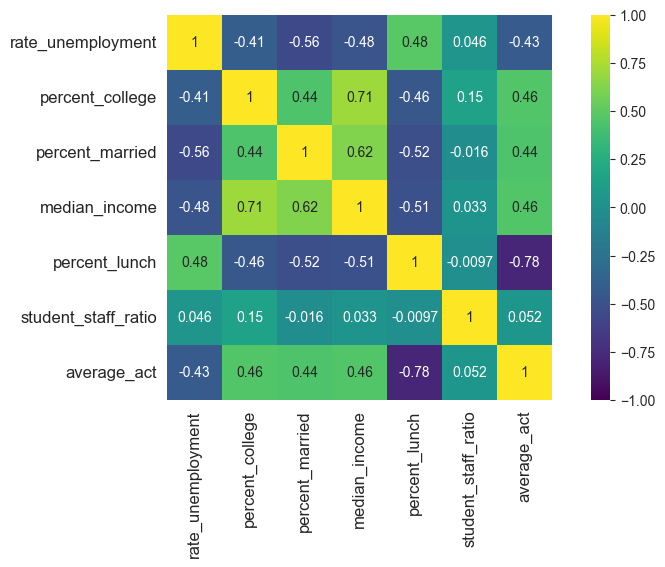

In [81]:
predictor_variables = ['rate_unemployment', 'percent_college', 'percent_married', 'median_income', 'percent_lunch', 'state', 'charter', 'student_staff_ratio']

numerical_predictors = df[predictor_variables].select_dtypes(include = 'number').columns.to_list()

corr_matrix = df[numerical_predictors + ["average_act"]].corr()

plt.figure(figsize = (10, 5))

sns.heatmap(
    corr_matrix, vmax = 1, vmin = -1, square = True, annot = True, cmap = "viridis"
)

plt.tick_params(labelsize=12)

plt.show()

- The correlation matrix shows that the student staff relationship has almost no linear relationship with average ACT.
    - Even less relationship with any of the other variables.
- Percent lunch (-0.78), median income (0.46), and percent college (0.46) all have strong relationships with average ACT.

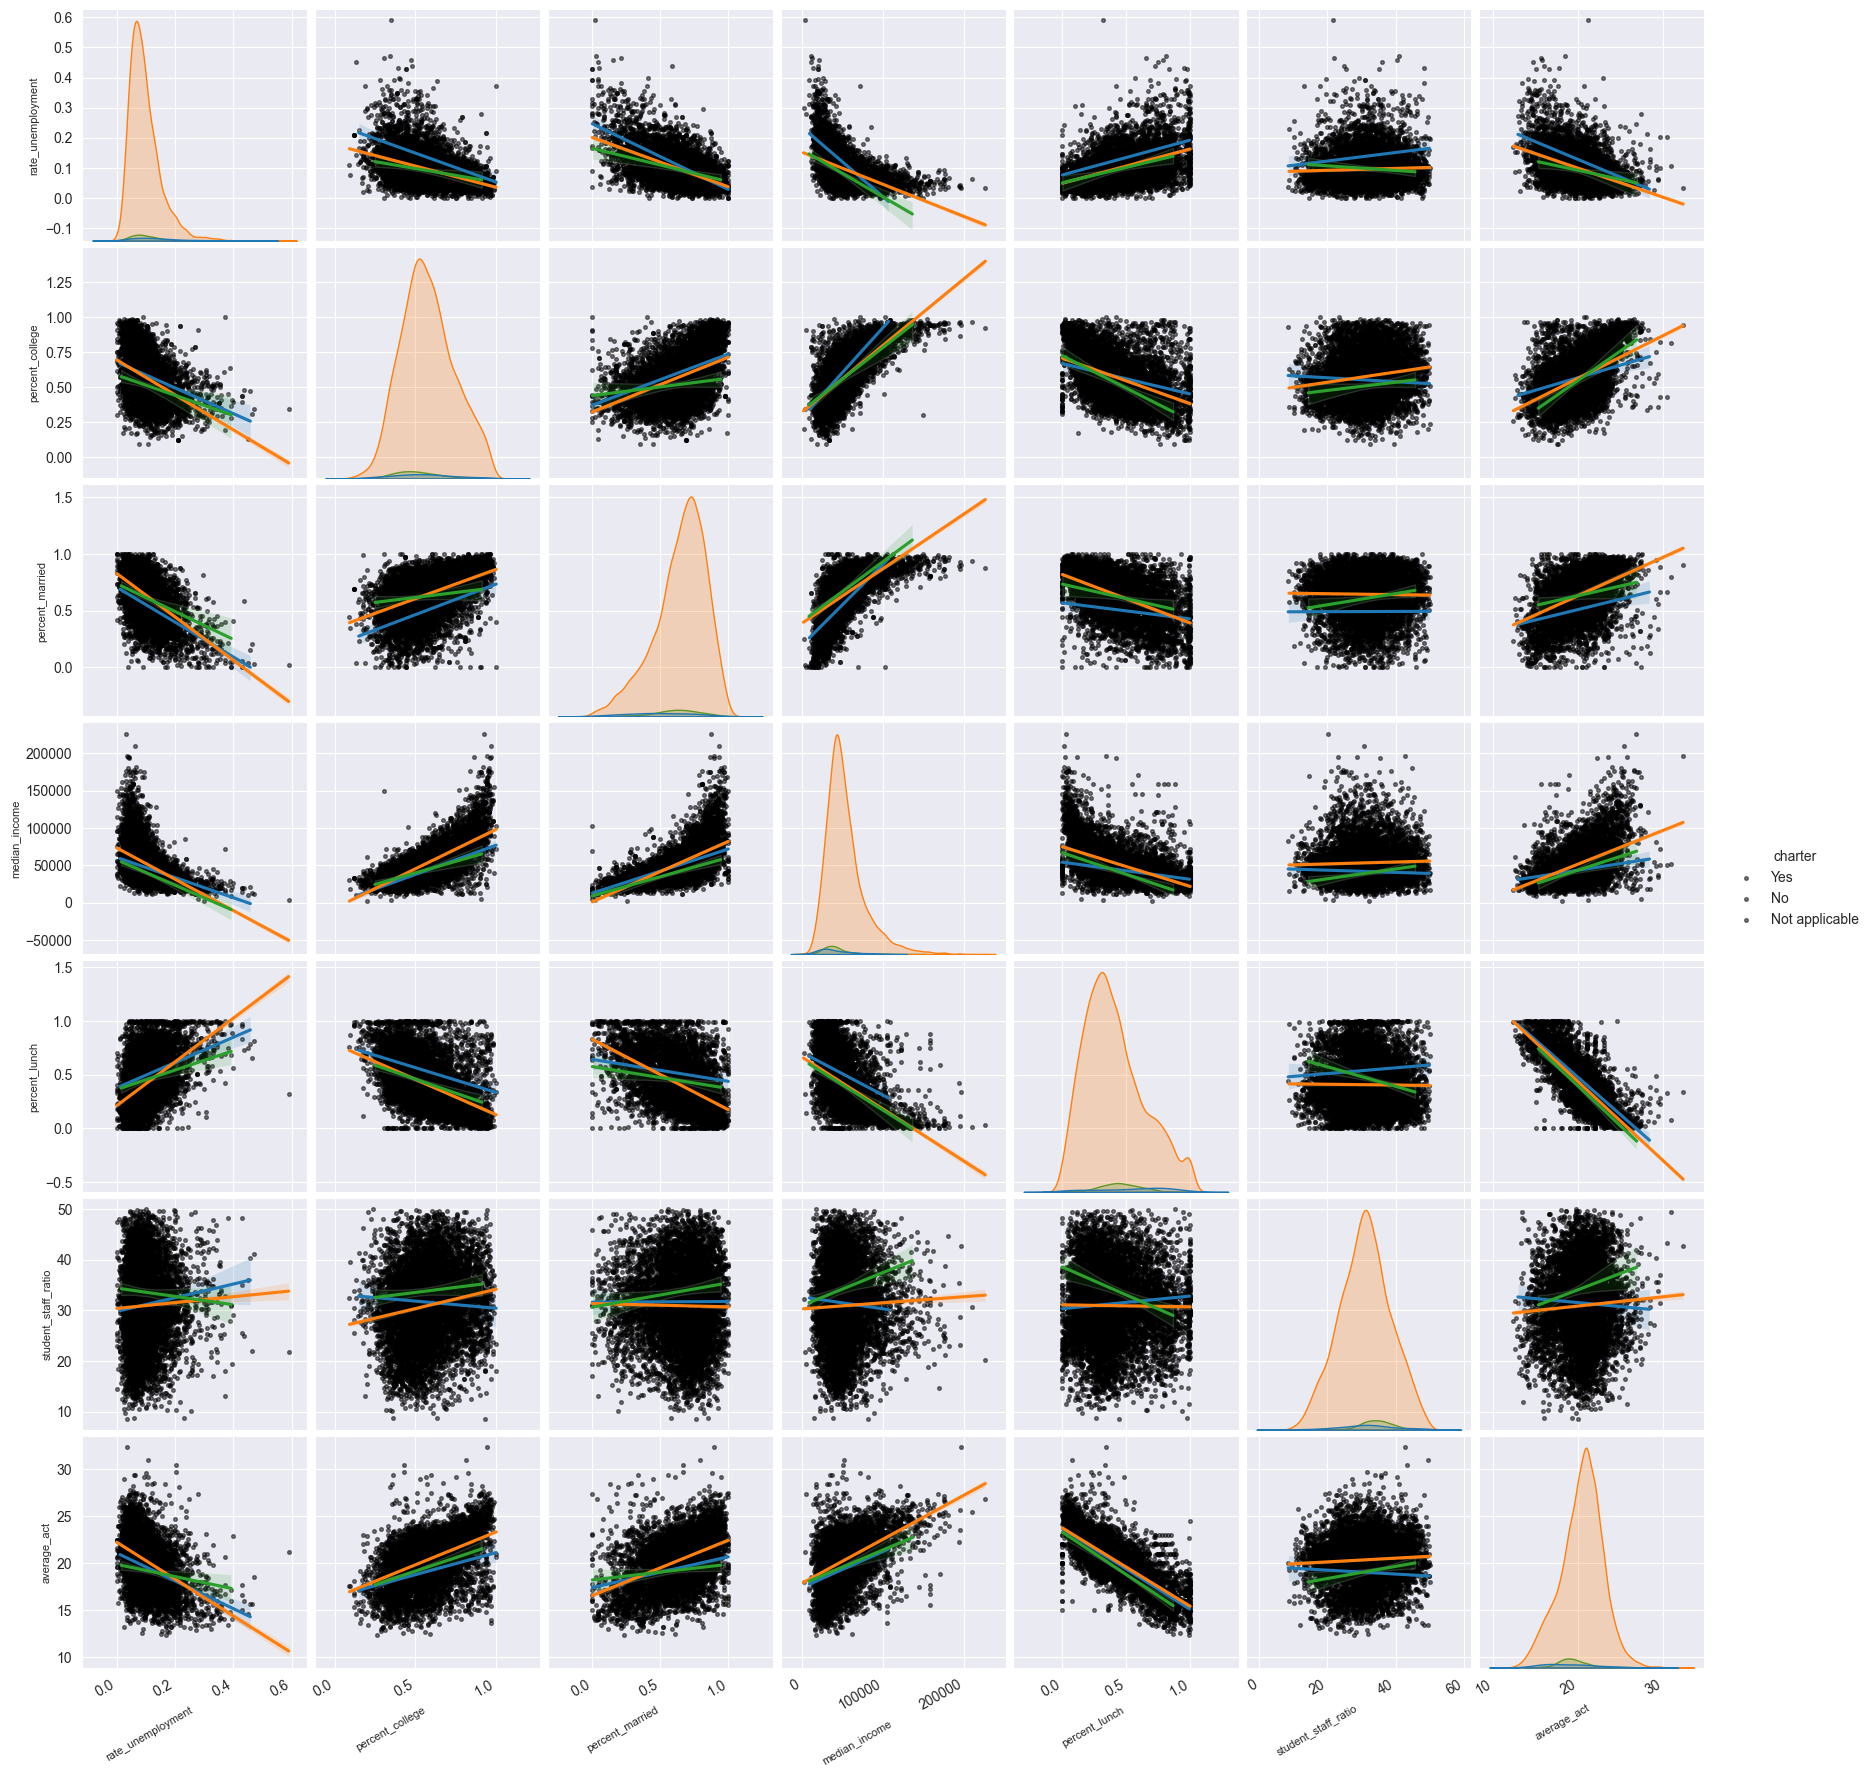

In [82]:
fig = sns.pairplot(
    data=df,
    vars=numerical_predictors + ['average_act'],
    hue='charter',
    kind="reg",
    plot_kws={"scatter_kws": {"alpha": 0.5, "color": "k", "s": 7},
    },
)

for ax in fig.axes.flat:
    if ax.get_xlabel() == 'CT Median Household Income':
        ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    ax.set_xlabel(ax.get_xlabel(), fontsize=8, rotation=30, ha='right')
    ax.set_ylabel(ax.get_ylabel(), fontsize=8)

    plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

plt.show()

- This pairplot can explore the relationships more by showing us the distribution of the data as well.

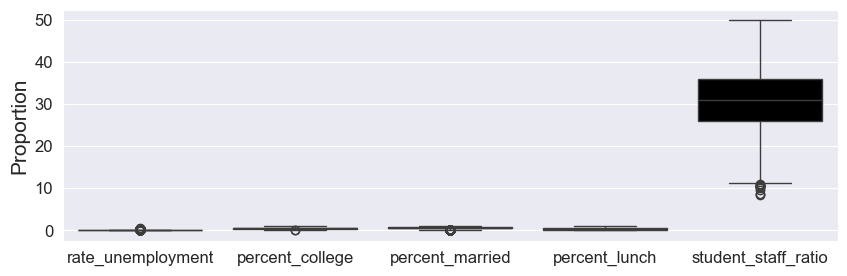

In [83]:
plt.figure(figsize=(10,3))

fractions = list(numerical_predictors)
fractions.remove('median_income')

sns.boxplot(data=df[fractions], color='k')

plt.ylabel('Proportion', fontsize=15)

plt.tick_params(labelsize=12)

plt.show()

- There are significant outliers in the student staff ratio

## Summary
- Key Correlation findings
    - The strongest linear relationship to average ACT was percent lunch (-0.78) and the weakest was the student staff ratio (0.052).
- Outliers
    - There are extreme outliers in the student staff ratio variable.
        - Could filter the ratios to an acceptable range or see is normalization can help.

# Modeling

## Single input models

### Median income

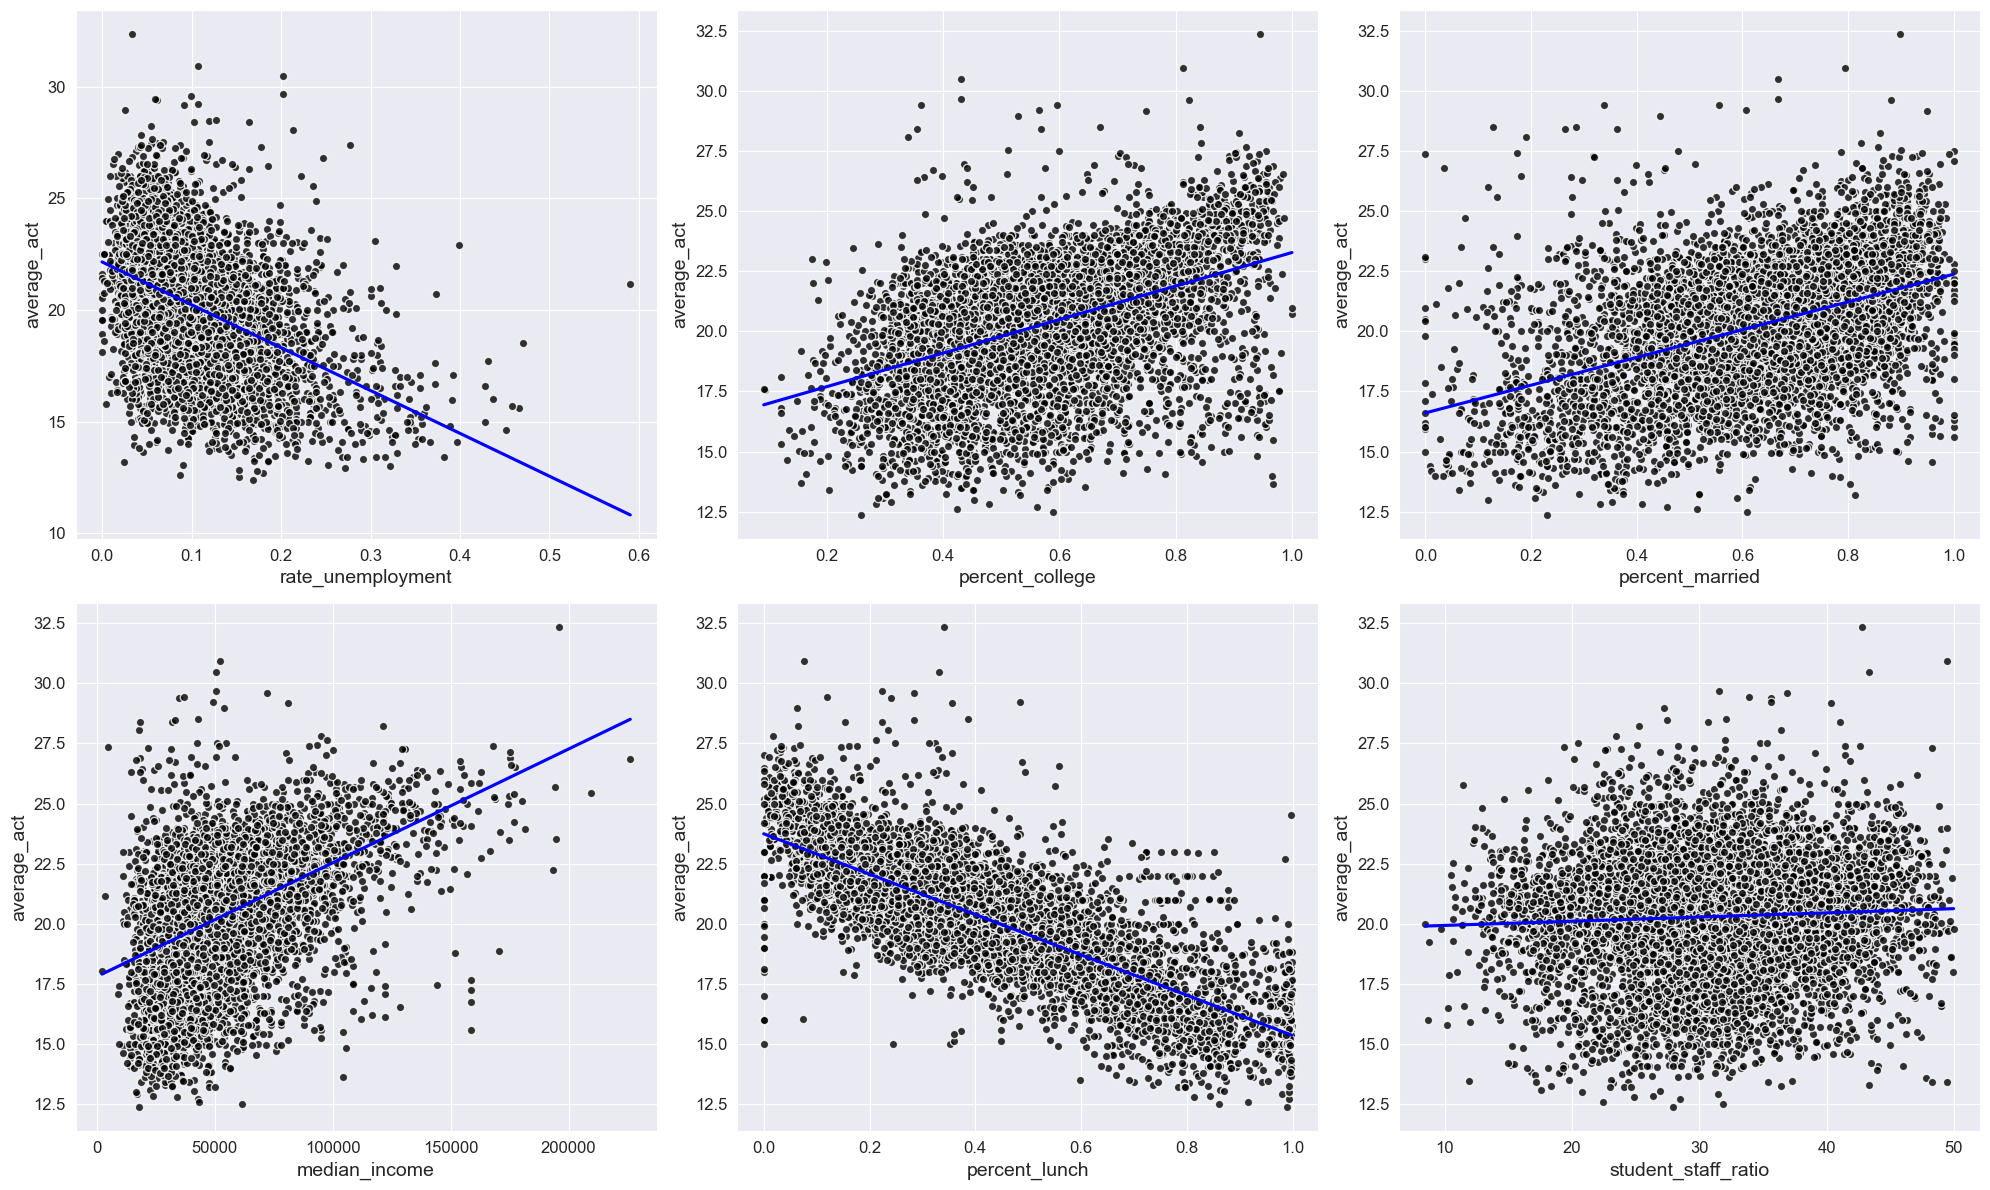

In [ ]:
predictor_variables = [
    'rate_unemployment', 'percent_college', 'percent_married',
    'median_income', 'percent_lunch', 'student_staff_ratio'
]

target_variable = 'average_act'

fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (20, 12))

axes_flat = axes.flatten()

for i, var in enumerate(predictor_variables):
    
    ax = axes_flat[i]
    
    sns.regplot(
        data = df,
        x = var,
        y = target_variable,
        ax = ax,
        color = 'blue',
        ci = False,
        scatter_kws = {'color': 'black', 'edgecolors': 'white', 'linewidths': 1}
    )
    
    ax.set_xlabel(var, fontsize = 14)
    ax.set_ylabel(target_variable, fontsize = 14)
    
    ax.tick_params(labelsize = 12)

plt.tight_layout()
plt.show()

- Strong relationships
    - This regression plot clearly shows the steep negative slope for percent lunch and percent college / median income steep positive slopes. 
- Weak relationships
    - The slope is almost flat (0) for the student staff ratio

In [90]:
model_median_income = smf.ols(formula='average_act ~ median_income', data=df).fit()
print(model_median_income.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     1935.
Date:                Wed, 22 Oct 2025   Prob (F-statistic):               0.00
Time:                        19:26:54   Log-Likelihood:                -16043.
No. Observations:                7227   AIC:                         3.209e+04
Df Residuals:                    7225   BIC:                         3.210e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        17.8024      0.063    284.791

- The regression results show that median income can account for ~21.1% of the variance in average ACT on it's own.
- the P-value also indicates that the relationship between median income and average ACT is statistically significant.

In [98]:
print("R-squared:",model_median_income.rsquared)

y_hat = model_median_income.predict()
print("Y-hat:", np.sqrt(mean_squared_error(df['average_act'], y_hat)).round(3))

print("Mean Absolute Error:", mean_absolute_error(df['average_act'], y_hat))

R-squared: 0.21120952396595682
Y-hat: 2.228
Mean Absolute Error: 1.7129524231135274


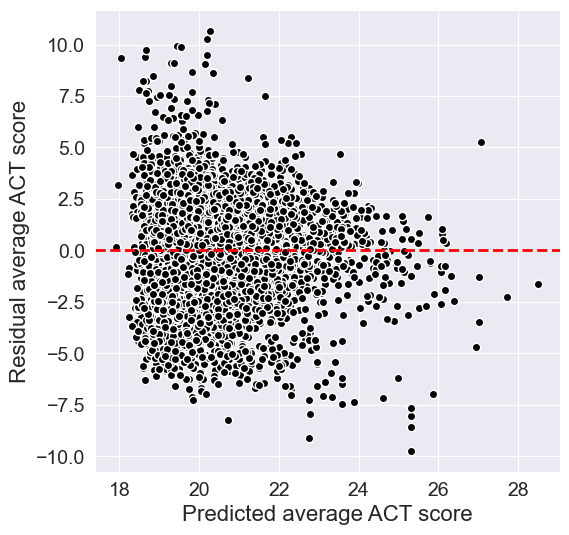

In [ ]:
plt.figure(figsize=(6, 6))

plt.plot(y_hat, model_median_income.resid, 'ko', mec = 'w')
plt.axhline(0, color = 'r', linestyle='dashed', lw = 2)

plt.xlabel('Predicted average ACT score', fontsize = 16)
plt.ylabel('Residual average ACT score', fontsize = 16)

plt.tick_params(labelsize = 14)

plt.show()

- The residual plot is more fan shaped than random.
    - suggests that the current model is to simple and is likely missing important variables.

### Unemployment Rate

In [117]:
model_ru = smf.ols(formula='average_act ~ rate_unemployment', data=df).fit()
print(model_ru.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     1669.
Date:                Wed, 22 Oct 2025   Prob (F-statistic):               0.00
Time:                        20:12:10   Log-Likelihood:                -16149.
No. Observations:                7227   AIC:                         3.230e+04
Df Residuals:                    7225   BIC:                         3.232e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            22.1511      0.05

- The R-Squared shows that unemployment rate can explain ~18.8% of the variance in average ACT
    - The P-value shows that this is significant, though it is less than the median income.

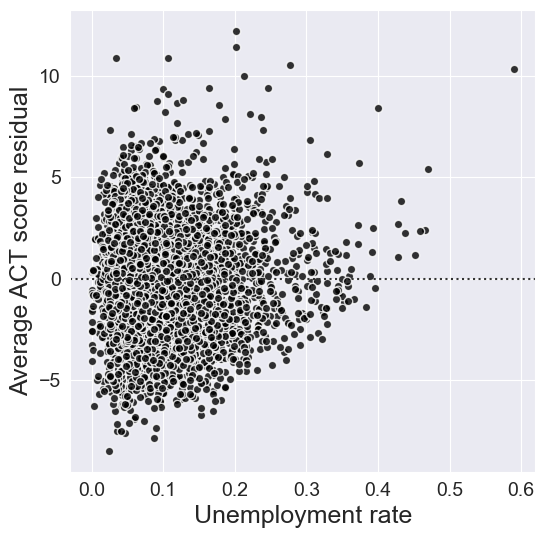

In [113]:
plt.figure(figsize = (6,6))

# residual plot
sns.residplot(data = df,
              x = 'rate_unemployment',
              y = 'average_act',
              scatter_kws={'color': 'black', 'edgecolors': 'white', 'linewidths': 1})

# Add axis labels
plt.xlabel('Unemployment rate', fontsize = 18)
plt.ylabel('Average ACT score residual', fontsize = 18)

# Increase the fontsize of the tick labels
plt.tick_params(labelsize = 14)

plt.show()

- Shows a fanning pattern like median income did, which suggests that unemployment rate is not a good predictor on its own.

### Student Staff Ratio

In [115]:
model_student_staff = smf.ols(formula = 'average_act ~ student_staff_ratio', data = df).fit()
print(model_student_staff.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     19.80
Date:                Wed, 22 Oct 2025   Prob (F-statistic):           8.72e-06
Time:                        20:07:29   Log-Likelihood:                -16891.
No. Observations:                7227   AIC:                         3.379e+04
Df Residuals:                    7225   BIC:                         3.380e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              19.7572    

- The P-value shows that the student staff ratio is statistically significant and has some sort of effect on average ACT.
    - However, the R-squared value shows that this model explains only ~0.03% of the variance in average ACT which is very low.

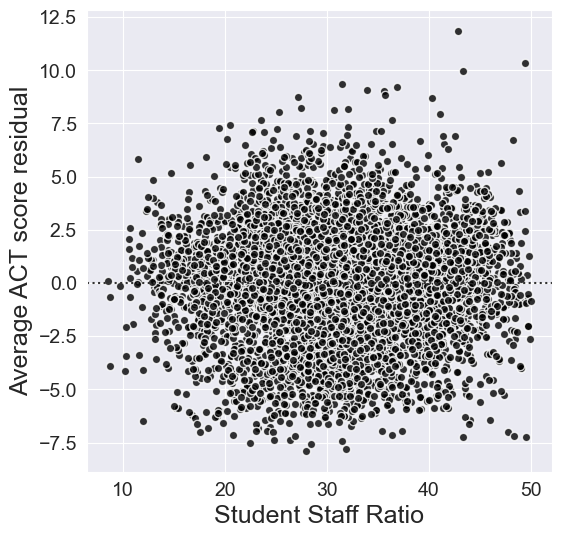

In [118]:
plt.figure(figsize = (6,6))

# residual plot
sns.residplot(data = df,
              x = 'student_staff_ratio',
              y = 'average_act',
              scatter_kws={'color': 'black', 'edgecolors': 'white', 'linewidths': 1})

# Add axis labels
plt.xlabel('Student Staff Ratio', fontsize = 18)
plt.ylabel('Average ACT score residual', fontsize = 18)

# Increase the fontsize of the tick labels
plt.tick_params(labelsize=14)

plt.show()

- Unlike the previous residual plots this shows that student staff ratio gives no real information about the average ACT.

### Percent Lunch

In [122]:
model_pl = smf.ols(formula='average_act ~ percent_lunch', data=df).fit()

print(model_pl.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                 1.149e+04
Date:                Wed, 22 Oct 2025   Prob (F-statistic):               0.00
Time:                        20:22:10   Log-Likelihood:                -13462.
No. Observations:                7227   AIC:                         2.693e+04
Df Residuals:                    7225   BIC:                         2.694e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        23.7429      0.037    641.737

- These show that percent lunch can explain ~61.4% of the variance in average ACT on its own.
    - This is the single best predicitor and the P-value shows it to be significant.

## Quardratic Models

### Median Income

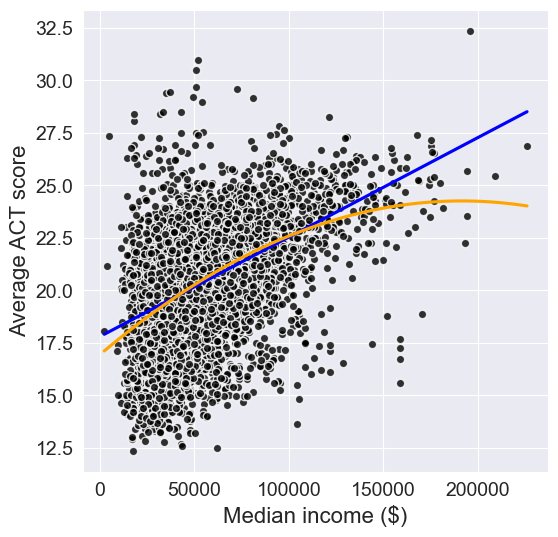

In [ ]:
plt.figure(figsize=(6, 6))

sns.regplot(data=df,
            x = 'median_income',
            y = 'average_act',
            color = 'blue',
            ci = False,
            scatter_kws = {'color': 'black', 'edgecolors': 'white', 'linewidths': 1})

sns.regplot(data=df,
            x = 'median_income',
            y = 'average_act',
            order = 2,
            color = 'orange',
            ci = False,
            scatter = False)

plt.xlabel('Median income ($)', fontsize=16)
plt.ylabel('Average ACT score', fontsize=16)

plt.tick_params(labelsize=14)

plt.show()

- This regression plot does suggest a non-linear relationship since the orange line (median income^2) seems to fit it better. 

In [ ]:
model_median_income2 = smf.ols(
    formula = 'average_act ~ median_income + I(median_income**2)',
    data = df).fit()

print(model_median_income2.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     1014.
Date:                Wed, 22 Oct 2025   Prob (F-statistic):               0.00
Time:                        19:49:46   Log-Likelihood:                -16007.
No. Observations:                7227   AIC:                         3.202e+04
Df Residuals:                    7224   BIC:                         3.204e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                16.94

In [110]:
print("P-values:",model_median_income2.pvalues)
print()
print("*" * 80)
print("annova", anova_lm(model_median_income, model_median_income2))
print()
print("*" * 80)
print("Mean Absolute Error:", mean_absolute_error(df['average_act'], model_median_income.predict()))
print()
print("*" * 80)
print("Mean Absolute Error (median income^2):", mean_absolute_error(df['average_act'], model_median_income2.predict()))


P-values: Intercept                0.000000e+00
median_income            2.250234e-99
I(median_income ** 2)    1.294562e-17
dtype: float64

********************************************************************************
annova    df_resid           ssr  df_diff     ss_diff          F        Pr(>F)
0    7225.0  35863.965498      0.0         NaN        NaN           NaN
1    7224.0  35503.338443      1.0  360.627055  73.378166  1.294562e-17

********************************************************************************
Mean Absolute Error: 1.7129524231135274

********************************************************************************
Mean Absolute Error (median income^2): 1.6972357564060807


- This shows that the relationship between median income and average ACT is not a simple linear relationship.
    - The R-squared for this is higher at ~21.9% explained variance.
    - The P-value also shows that it is statistically significant.

### Unemployment Rate

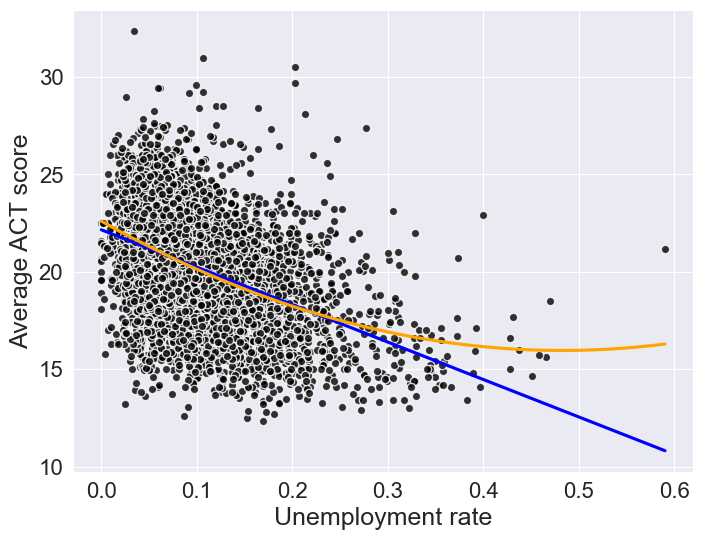

In [ ]:
plt.figure(figsize = (8,6))

sns.regplot(x = 'rate_unemployment',
            y = 'average_act',
            color = 'blue',
            data = df,
            ci = False,
            scatter_kws = {'color': 'black', 'edgecolors': 'white', 'linewidths': 1})

sns.regplot(x = 'rate_unemployment',
            y = 'average_act',
            color = 'orange',
            order = 2,
            data = df,
            ci = False,
            scatter = False)

plt.xlabel('Unemployment rate', fontsize = 18)
plt.ylabel('Average ACT score', fontsize = 18)

plt.tick_params(labelsize = 16)

plt.show()

In [120]:
model_ru2 = smf.ols(formula='average_act ~ rate_unemployment + I(rate_unemployment**2)', data=df).fit()
print(model_ru2.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     864.8
Date:                Wed, 22 Oct 2025   Prob (F-statistic):               0.00
Time:                        20:19:45   Log-Likelihood:                -16125.
No. Observations:                7227   AIC:                         3.226e+04
Df Residuals:                    7224   BIC:                         3.228e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

- A quadratic model improves the variance explained by Unemployment rate.
    - Its improvement is not by much though, similarly to median income.

## Multiple Linear Regression

### All socioeconomic variables

In [123]:
model = smf.ols(
    formula='average_act ~ rate_unemployment + percent_college + percent_married + median_income + percent_lunch',
    data=df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     2438.
Date:                Wed, 22 Oct 2025   Prob (F-statistic):               0.00
Time:                        20:26:19   Log-Likelihood:                -13328.
No. Observations:                7227   AIC:                         2.667e+04
Df Residuals:                    7221   BIC:                         2.671e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            22.6966      0.13

- R-squared shows that the combination of the 5 variables can explain ~62.8% of the variance in average ACT

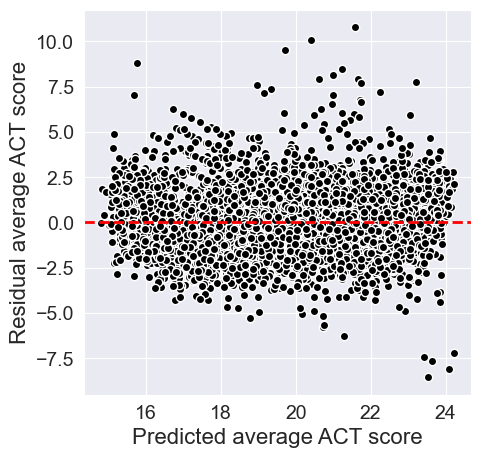

In [ ]:
y_hat = model.predict()

plt.figure(figsize=(5, 5))

plt.plot(y_hat, model.resid, 'ko', mec='w')
plt.axhline(0, color='r', linestyle='dashed', lw=2)

plt.xlabel('Predicted average ACT score', fontsize=16)
plt.ylabel('Residual average ACT score', fontsize=16)

plt.tick_params(labelsize=14)

plt.show()

In [125]:
print("Mean Absolute Error:", mean_absolute_error(df['average_act'], model.predict()))

Mean Absolute Error: 1.1453389746710516


### Summary
- The best single predictor of average ACT is percent lunch at ~61.4% variance explained. 
- Median income and unemployment rate can be improved, though only slightly by making them quadratic.
- Student staff ratio is the weakest predictor at ~0.03% variance explained.
- Using all 5 socioeconomic variables gets the variance explained to ~62.8%.
    - This is an improvement over just percent lunch but not a large one.

### Reduced model

In [126]:
model_reduced = smf.ols(
    formula = 'average_act ~ rate_unemployment + percent_college + percent_lunch',
    data=df).fit()

print(model_reduced.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     4063.
Date:                Wed, 22 Oct 2025   Prob (F-statistic):               0.00
Time:                        20:34:34   Log-Likelihood:                -13328.
No. Observations:                7227   AIC:                         2.666e+04
Df Residuals:                    7223   BIC:                         2.669e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            22.6395      0.10

- The reduced model can explain the same total variance in average ACT that the full model can.
    - All the the predicitors used are siginficant and the model is more efficient overall.

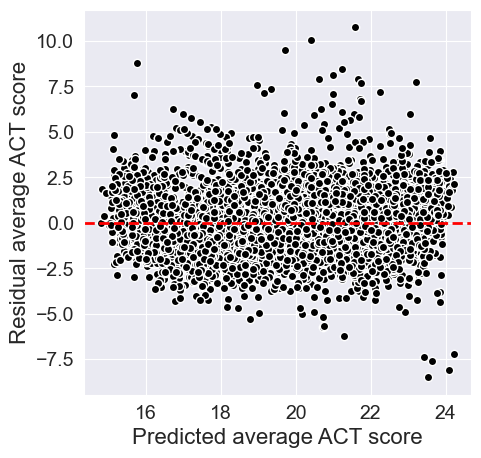

In [127]:
plt.figure(figsize = (5, 5))

plt.plot(y_hat, model_reduced.resid, 'ko', mec = 'w')
plt.axhline(0, color='r', linestyle = 'dashed', lw = 2)

plt.xlabel('Predicted average ACT score', fontsize = 16)
plt.ylabel('Residual average ACT score', fontsize = 16)

plt.tick_params(labelsize=14)

plt.show()

- The residual plot shows that this is a good model. It has randomness but the points are scattered around zero.
    - Since there is still randomness there could be room for improvement.

In [131]:
mae_full = mean_absolute_error(df['average_act'], model.predict())
mae_reduced = mean_absolute_error(df['average_act'], model_reduced.predict())

r2_full = model.rsquared
r2_reduced = model_reduced.rsquared

print(pd.DataFrame({'Mean Absolute Error': [mae_full, mae_reduced],
              'R-squared': [r2_full, r2_reduced]},
              index=['full model', 'reduced model']).round(4))
print()

print("Anova:", anova_lm(model_reduced, model))

               Mean Absolute Error  R-squared
full model                  1.1453     0.6280
reduced model               1.1455     0.6279

Anova:    df_resid           ssr  df_diff   ss_diff         F    Pr(>F)
0    7223.0  16916.871810      0.0       NaN       NaN       NaN
1    7221.0  16915.868397      2.0  1.003413  0.214167  0.807219


- The reduced model has the same predictive power as the full model.
- ANOVA shows that adding the extra variables provides nno statistically significant improvement.